# Demonstration of anomaly detection with CVAE using DASHlink data

**Author: Milad Memarzadeh (milad.memarzadeh@nasa.gov)**


# Demonstration of anomaly detection with CVAE using DASHlink data

**Author: Milad Memarzadeh (milad.memarzadeh@nasa.gov)**


# Import Libraries

In [54]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, roc_curve, precision_recall_curve, average_precision_score
from sklearn.utils import shuffle
#from source.modelsCondVAE import *
from source.utilsCondVAEs5 import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [55]:
latent_dim = 6

save_dir="./CompressAE/A4/"+str(latent_dim)+"/"


# Load and preprocess data

In [56]:
X_train = np.load(save_dir+'X_train.npy')
y_train = np.load(save_dir+'y_train.npy')
X_val = np.load(save_dir+'X_val.npy')
y_val = np.load(save_dir+'y_val.npy')
X_test = np.load(save_dir+'X_test.npy')
y_test = np.load(save_dir+'y_test.npy')

X_train_size = os.path.getsize(save_dir+'X_train.npy')
X_val_size = os.path.getsize(save_dir+'X_val.npy')
X_test_size = os.path.getsize(save_dir+'X_test.npy')

# Create Data Loaders for Labeled and Unlabeled Data

In [57]:
z_train = np.load(save_dir+'z_train.npy')
z_val = np.load(save_dir+'z_val.npy')
z_test = np.load(save_dir+'z_test.npy')

z_train_size = os.path.getsize(save_dir+'z_train.npy')
z_val_size = os.path.getsize(save_dir+'z_val.npy')
z_test_size = os.path.getsize(save_dir+'z_test.npy')

In [58]:
train_ratio = z_train_size / X_train_size if X_train_size else float('nan')
print(f"Uncompressed: {X_train_size} bytes\nCompressed: {z_train_size} bytes\nRatio: {train_ratio:.3f}\n")
val_ratio = z_val_size / X_val_size if X_val_size else float('nan')
print(f"Uncompressed: {X_val_size} bytes\nCompressed: {z_val_size} bytes\nRatio: {val_ratio:.3f}\n")
test_ratio = z_test_size / X_test_size if X_test_size else float('nan')
print(f"Uncompressed: {X_test_size} bytes\nCompressed: {z_test_size} bytes\nRatio: {test_ratio:.3f}\n")


Uncompressed: 1344048 bytes
Compressed: 806480 bytes
Ratio: 0.600

Uncompressed: 1344048 bytes
Compressed: 806480 bytes
Ratio: 0.600

Uncompressed: 4031928 bytes
Compressed: 2419208 bytes
Ratio: 0.600



In [59]:
def np2df(x):
    """
    Convert numpy array to pandas DataFrame.
    :param x: numpy array
    :return: pandas DataFrame
    """
    # Create a DataFrame with default index and column names
    T, C = x.shape                      # (85555, 10)
    df = pd.DataFrame(
    x,
    index=np.arange(T),             # treat rows as “sample index”; replace with timestamps if you have them
    columns=[f"ch{i+1}" for i in range(C)]
    )
    return df
X_train_df = np2df(X_train)
X_val_df = np2df(X_val)
X_test_df = np2df(X_test)
z_train_df = np2df(z_train)
z_val_df = np2df(z_val)
z_test_df = np2df(z_test)

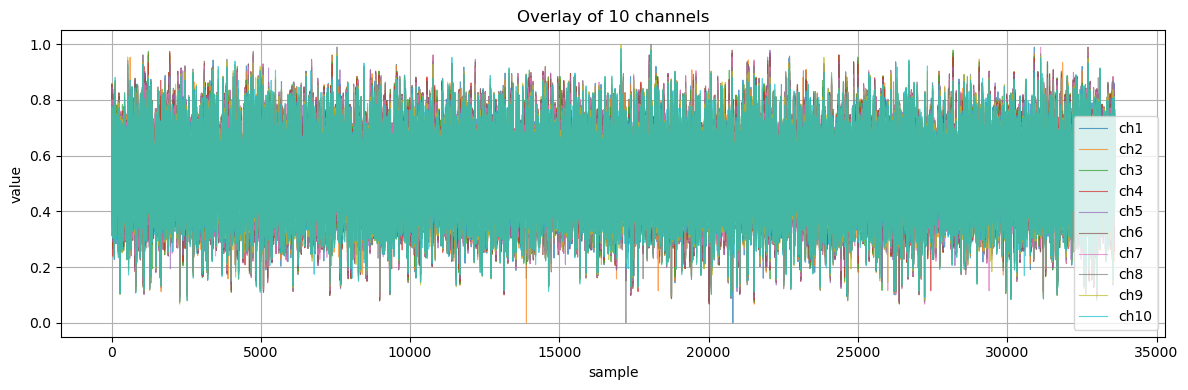

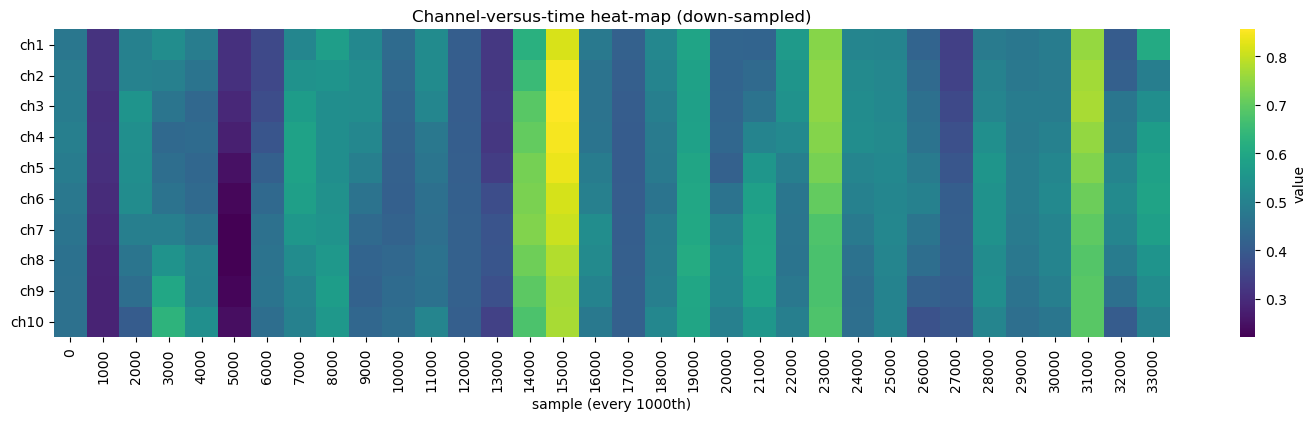

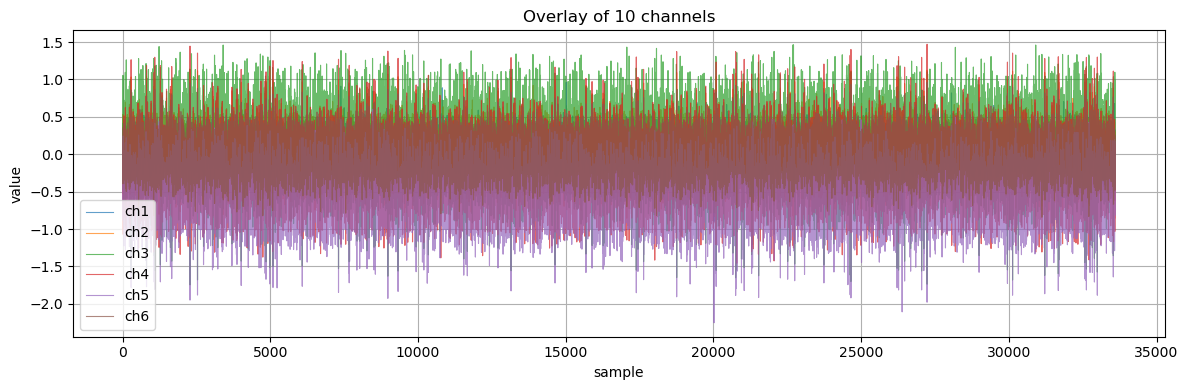

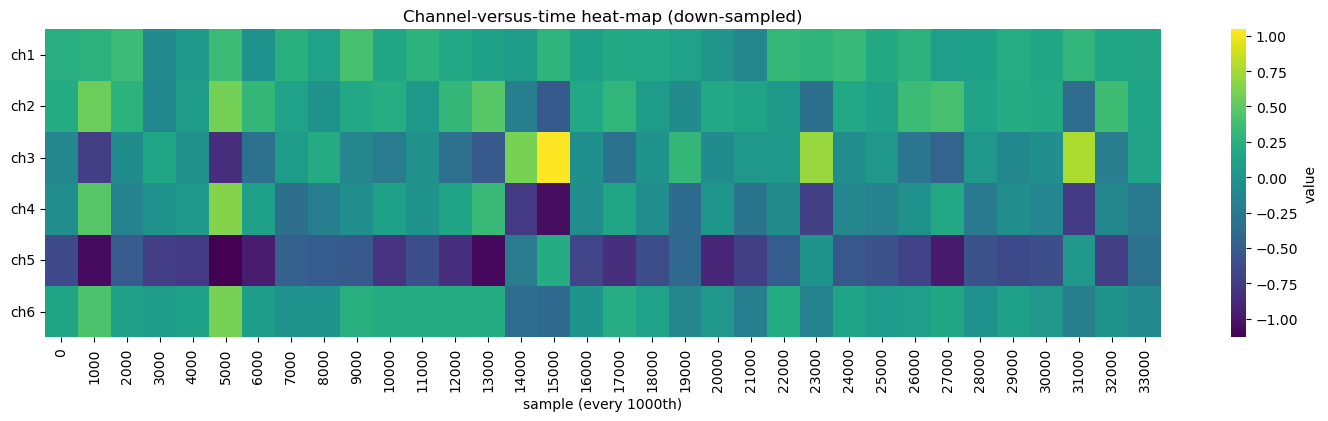

In [60]:
def plot(df, step=10):
    """
    Plot the DataFrame.
    :param df: pandas DataFrame
    """
    ax = df.plot(figsize=(12, 4), lw=0.8, alpha=0.7)
    ax.set(title="Overlay of 10 channels", xlabel="sample", ylabel="value"); ax.grid(True)
    plt.tight_layout(); plt.show()

    #fig, axs = plt.subplots(C, 1, figsize=(12, 12), sharex=True,
    #                    gridspec_kw=dict(hspace=0))
    #for i, col in enumerate(df.columns):
    #    axs[i].plot(df.index, df[col], lw=0.8)
    #    axs[i].set_ylabel(col, rotation=0, labelpad=20, ha="right")
    #axs[-1].set_xlabel("sample index")
    #plt.tight_layout(); plt.show()
    
    df_ds = df.iloc[::step, :]      

    plt.figure(figsize=(18, 4))
    sns.heatmap(df_ds.T, cmap="viridis", cbar_kws=dict(label="value"))
    plt.yticks(rotation=0); plt.xlabel(f"sample (every {step}th)")
    plt.title("Channel-versus-time heat-map (down-sampled)"); plt.show()

plot(X_val_df, step=1000)
plot(z_val_df, step=1000)
